Importing Modules

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats 
from scipy.stats import f

### Single Regression class

In [43]:
class SimpleLinearRegression:
    def __init__(self):
        self.b0 = None
        self.b1 = None
        self.X = None
        self.y_hat = None
        self.residuals = None
        self.MSE = None
        self.r_squared = None
        self.SSE = None
        self.SSR = None
        self.SST = None
        self.F_stat = None
        self.n = None

    def fit(self, X, y):
        X = np.array(X).flatten()
        y = np.array(y).flatten()
        self.n = len(X)
        self.X = X  # Store for interval estimation

        x_mean, y_mean = np.mean(X), np.mean(y)
        self.b1 = np.sum((X - x_mean) * (y - y_mean)) / np.sum((X - x_mean) ** 2)
        self.b0 = y_mean - self.b1 * x_mean

        self.y_hat = self.predict(X)
        self.residuals = y - self.y_hat

        self.SSE = np.sum((y - self.y_hat) ** 2)
        self.SST = np.sum((y - y_mean) ** 2)
        self.SSR = self.SST - self.SSE
        self.MSE = self.SSE / (self.n - 2)
        self.r_squared = 1 - self.SSE / self.SST

    def predict(self, X):
        X = np.array(X).flatten()
        return self.b0 + self.b1 * X

    def anova_table(self):
        df_reg = 1
        df_err = self.n - 2
        df_total = self.n - 1

        MSR = self.SSR / df_reg
        MSE = self.SSE / df_err
        self.F_stat = MSR / MSE

        anova_data = {
            'Source': ['Regression', 'Error', 'Total'],
            'Sum of Squares': [self.SSR, self.SSE, self.SST],
            'Degrees of Freedom': [df_reg, df_err, df_total],
            'Mean Square': [MSR, MSE, ""],
            'F-Statistic': [self.F_stat, "", ""]
        }
        return pd.DataFrame(anova_data)

    def hypothesis_test(self, alpha=0.05):
        df_reg = 1
        df_err = self.n - 2
        F_critical = scipy.stats.f.ppf(1 - alpha, df_reg, df_err)

        print("=" * 45)
        print(" Hypothesis Testing Results ")
        print("=" * 45)
        print(f"Null Hypothesis (H₀):     β₁ = 0")
        print(f"Alternative Hypothesis:  β₁ ≠ 0")
        print("-" * 45)
        print(f"F-statistic (F₀):        {self.F_stat:.4f}")
        print(f"Critical value (F_c):    {F_critical:.4f}")
        print("-" * 45)
        if self.F_stat > F_critical:
            print("Conclusion: Reject H₀ — significant relationship exists.")
        else:
            print("Conclusion: Fail to reject H₀ — no significant relationship.")
        print("=" * 45)

    def interval_estimation(self, alpha=0.05):
        x_vals = self.X
        x_mean = np.mean(x_vals)
        t_critical = scipy.stats.t.ppf(1 - alpha / 2, df=self.n - 2)

        SE_b1 = np.sqrt(self.MSE / np.sum((x_vals - x_mean) ** 2))
        SE_b0 = np.sqrt(self.MSE * (1/self.n + (x_mean**2) / np.sum((x_vals - x_mean) ** 2)))

        b0_interval = (
            self.b0 - t_critical * SE_b0,
            self.b0 + t_critical * SE_b0
        )
        b1_interval = (
            self.b1 - t_critical * SE_b1,
            self.b1 + t_critical * SE_b1
        )

        return { b0_interval, b1_interval}

    def plot(self, X, y):
        X = np.array(X).flatten()
        y = np.array(y).flatten()
        plt.figure(figsize=(8, 6))
        plt.scatter(X, y, color='blue', label='Data Points')
        plt.plot(X, self.predict(X), color='red', label='Regression Line')
        plt.xlabel("Feature")
        plt.ylabel("Target")
        plt.title("Simple Linear Regression")
        plt.legend()
        plt.grid(True)
        plt.show()


### Multiple Regression class

In [44]:
class MultipleLinearRegression:
    def __init__(self):
    
        self.B = None  # Coefficients, including intercept
        self.MSE = None
        self.n = None  # Number of samples
        self.p = None  # Number of predictors including intercept
        self.SSE = None  # Sum of Squared Errors
        self.SSR = None  # Sum of Squares for Regression
        self.SST = None  # Total Sum of Squares
        self.F_stat = None  # F-statistic
        self.r_squared = None  # Coefficient of determination

    def fit(self, X, y):
      
        # 1. Ensure X and y are numpy arrays
        X = np.array(X)
        y = np.array(y)

        # 2. Add a column of ones to X for the intercept term
        self.n = X.shape[0]
        self.p = X.shape[1] + 1  # Number of predictors (including intercept)
        X = np.c_[np.ones((self.n, 1)), X]

        # 3. Calculate the coefficients using the Normal Equation
        self.B = np.linalg.inv(X.T @ X) @ X.T @ y

        # 4. Calculate residuals and Mean Squared Error (MSE)
        y_hat = self.predict(X, add_bias=False)
        residuals = y - y_hat  # Residuals
        self.SSE = np.sum(residuals**2)
        self.SST = np.sum((y - np.mean(y))**2)
        self.SSR = self.SST - self.SSE
        self.MSE = self.SSE / (self.n - self.p)  # Divide by (n - p)
        
        # 5. Calculate R-squared
        self.r_squared = 1 - (self.SSE / self.SST)

    def predict(self, X, add_bias=True):
   
        if self.B is None:
            raise ValueError("The model has not been fitted yet.")

        X = np.array(X)
        if add_bias:
            X = np.c_[np.ones((X.shape[0], 1)), X]

        return X @ self.B

    def anova_table(self):
       
        if self.B is None:
            raise ValueError("The model has not been fitted yet.")

        # Degrees of Freedom
        df_regression = self.p - 1  # Degrees of freedom for regression
        df_error = self.n - self.p  # Degrees of freedom for error
        df_total = self.n - 1  # Total degrees of freedom

        # Mean Squares
        MSR = self.SSR / df_regression  # Mean Square for Regression
        MSE = self.SSE / df_error  # Mean Square for Error

        # F-statistic
        self.F_stat = MSR / MSE

        # Assemble the ANOVA table
        anova_data = {
            'Source': ['Regression', 'Error', 'Total'],
            'Sum of Squares': [self.SSR, self.SSE, self.SST],
            'Degrees of Freedom': [df_regression, df_error, df_total],
            'Mean Square': [MSR, MSE, ""],
            'F-Statistic': [self.F_stat, "", ""]
        }

        anova_table = pd.DataFrame(anova_data)
        return anova_table

    def hypothesis_test(self, alpha):
     
        if self.B is None:
            raise ValueError("The model has not been fitted yet.")

        # Critical value for F-distribution
        df_regression = self.p - 1
        df_error = self.n - self.p
        F_critical = scipy.stats.f.ppf(1 - alpha, df_regression, df_error)

        # Hypothesis conclusion
        if self.F_stat > F_critical:
            conclusion = ("Since F_0 > F_c, we reject the null hypothesis.\n"
                          "Therefore, there's a relationship between the predictors and the target.")
        else:
            conclusion = ("Since F_c > F_0, we don't reject the null hypothesis.\n"
                          "Therefore, there's no relationship between the predictors and the target.")

        # Print the results
        print("="*45)
        print(" Hypothesis Testing Results ")
        print("="*45)
        print(f"{'Null Hypothesis (H_0):':<25} All coefficients except intercept are 0")
        print(f"{'Alternative Hypothesis (H_a):':<25} At least one coefficient ≠ 0")
        print("-"*45)
        print(f"{'F-statistic (F_0):':<25} {self.F_stat:.4f}")
        print(f"{'Critical value (F_c):':<25} {F_critical:.4f}")
        print("-"*45)
        print(f"{conclusion}")
        print("="*45)

    def partial_f_test_all(self, x, y, alpha=0.05):
        # ensure arrays
        x = np.asarray(x)
        y = np.asarray(y)
        n, k = x.shape

        # fit full model
        self.fit(x, y)
        SSE_full = self.SSE
        p_full = self.p           # includes intercept
        MSE_full = self.SSE / (n - p_full)

         # Print hypothesis statements
        print("="*60)
        print("Partial F-Test for Each Feature")
        print("="*60)
        print("Null Hypothesis H₀: β_i = 0  (feature j has no effect)")
        print("Alternative H₁:    β_i ≠ 0  (feature j contributes)")
        print(f"Significance level: α = {alpha}")
        print("-"*60)

        results = []
        for j in range(k): # loop over each feature j = 0 : k−1
            # build reduced X by dropping column j
            x_partial = np.delete(x, j, axis=1)

            # fit reduced model
            red = MultipleLinearRegression()
            red.fit(x_partial, y)
            SSE_red = red.SSE

            # numerator df = 1 (we remove exactly one β)
            df_num = 1
            df_den = n - p_full

            #(SSE_reduced - SSE_full)/1  divided by MSE_full
            F_stat = (SSE_red - SSE_full) / MSE_full
            F_crit = f.ppf(1 - alpha, df_num, df_den)
            conclusion = "Reject H₀" if F_stat > F_crit else "Fail to Reject"

            results.append({
                'Feature': f'B{j}',
                'F-stat': round(F_stat, 4),
                'F-crit': round(F_crit, 4),
                'Conclusion': conclusion
            })

        df = pd.DataFrame(results)
        print("="*60)
        print(df.to_string(index=False))
        print("="*60)

    def interval_estimation(self, X_scaled_multi, alpha=0.05, sigma=None):
    
        if self.B is None:
            raise ValueError("The model has not been fitted yet.")

        # Critical value for T-distribution (default)
        if sigma is None:
            t_critical = scipy.stats.t.ppf(1 - alpha / 2, self.n - self.p)
            use_sigma = np.sqrt(self.MSE)  # Use sample-based standard error
        else:
            z_critical = scipy.stats.norm.ppf(1 - alpha / 2)
            use_sigma = sigma  # Use provided population standard deviation

        # Confidence intervals
        confidence_intervals = []
        
        # Reconstruct the feature matrix with the intercept term
        X = np.c_[np.ones((self.n, 1)), np.array(X_scaled_multi)]
        
        # Calculate the covariance matrix
        try:
            covariance_matrix = np.linalg.inv(X.T @ X) # estimator +- d * sqrt(mse2 (xt@x))
        except np.linalg.LinAlgError:
            raise ValueError("The matrix X.T @ X is singular. Check for collinearity or other issues in the dataset.")

        for i in range(self.p):
            standard_error = np.sqrt(use_sigma**2 * covariance_matrix[i, i])
            if sigma is None:
                # Use T-distribution
                lower_bound = self.B[i] - t_critical * standard_error
                upper_bound = self.B[i] + t_critical * standard_error
            else:
                # Use Z-distribution
                lower_bound = self.B[i] - z_critical * standard_error
                upper_bound = self.B[i] + z_critical * standard_error
            confidence_intervals.append((lower_bound, upper_bound))

        return confidence_intervals
    
    def plot(self, X, y):
        if self.B is None:
            raise ValueError("The model has not been fitted yet.")

        # Ensure X and y are numpy arrays
        X = np.array(X)
        y = np.array(y)

        if X.shape[1] != 2:
            raise ValueError("Plotting is only supported for datasets with exactly 2 features.")

        # Generate grid for the regression plane
        x1_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 50)
        x2_range = np.linspace(X[:, 1].min(), X[:, 1].max(), 50)
        x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)

        # Predicted values for the grid
        y_pred_grid = (
            self.B[0] + self.B[1] * x1_grid + self.B[2] * x2_grid
        )  # Plane equation

        # Create 3D scatter plot with regression plane
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(111, projection="3d")
        ax.scatter(X[:, 0], X[:, 1], y, color="blue", label="Data points")
        ax.plot_surface(x1_grid, x2_grid, y_pred_grid, color="red", alpha=0.5, label="Regression plane")
        ax.set_xlabel("Feature 1")
        ax.set_ylabel("Feature 2")
        ax.set_zlabel("Target")
        ax.set_title("Multiple Linear Regression with Regression Plane")
        plt.legend()
        plt.show()

# Now let's test it on our data

### 1. Data Preprocessing

In [45]:
df = pd.read_csv('Student_Performance.csv')

In [46]:
df.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [47]:
df.isnull().sum()

Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64

In [48]:
df.duplicated().sum()

np.int64(127)

In [49]:
df.drop_duplicates(inplace=True)

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9873 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     9873 non-null   int64  
 1   Previous Scores                   9873 non-null   int64  
 2   Extracurricular Activities        9873 non-null   object 
 3   Sleep Hours                       9873 non-null   int64  
 4   Sample Question Papers Practiced  9873 non-null   int64  
 5   Performance Index                 9873 non-null   float64
dtypes: float64(1), int64(4), object(1)
memory usage: 539.9+ KB


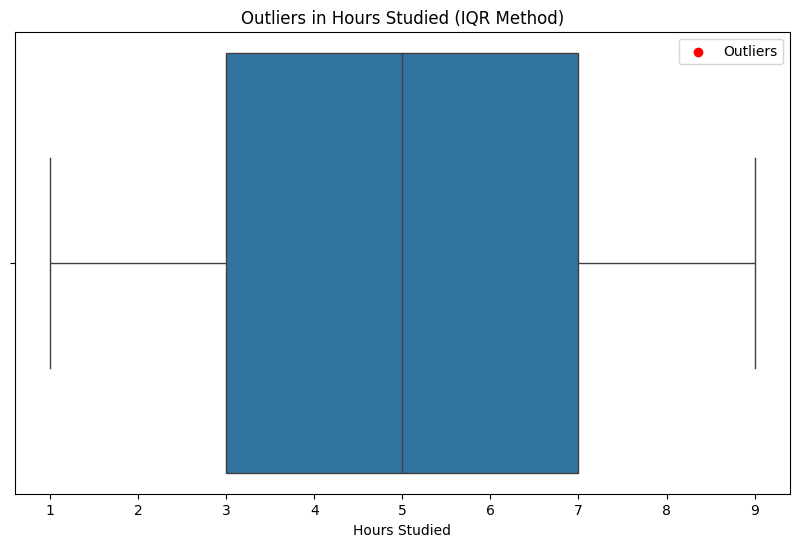

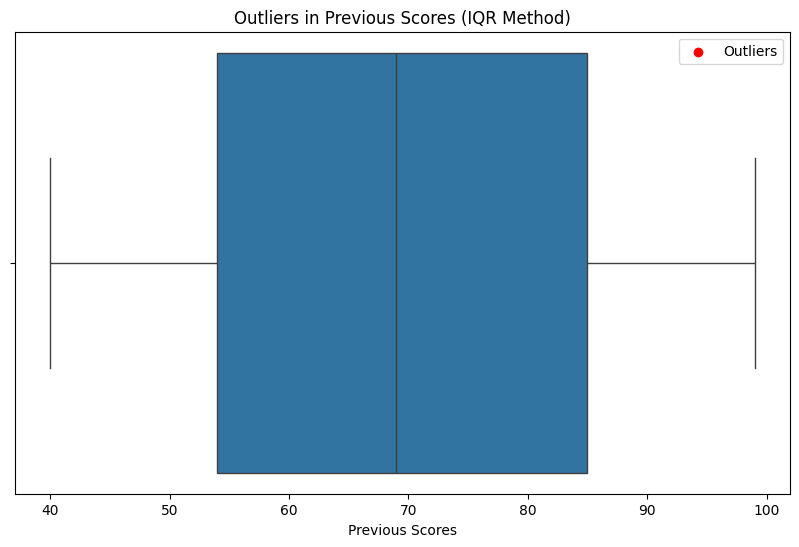

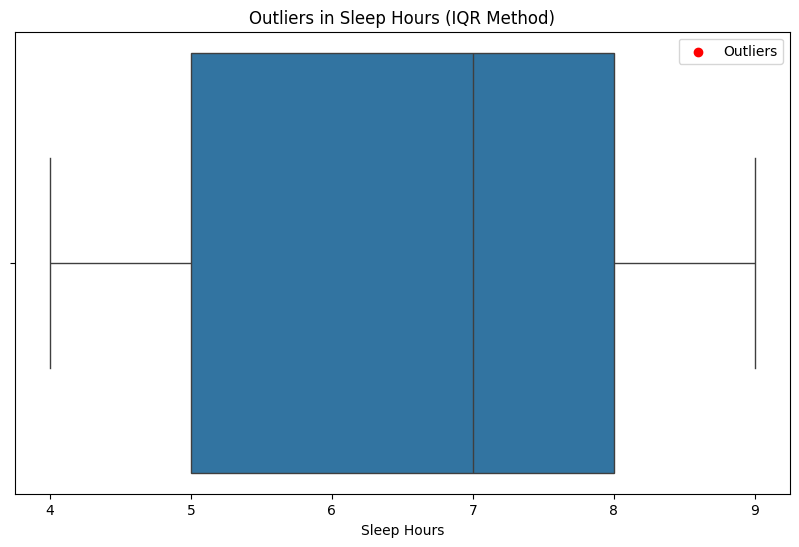

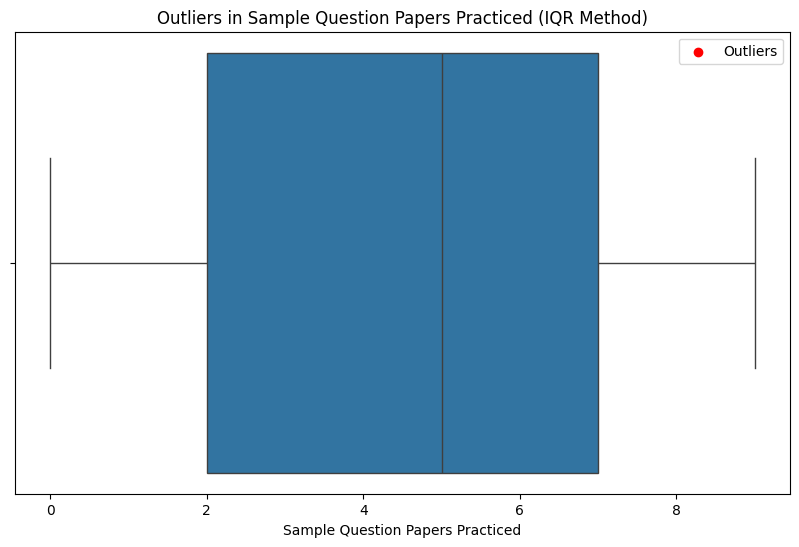

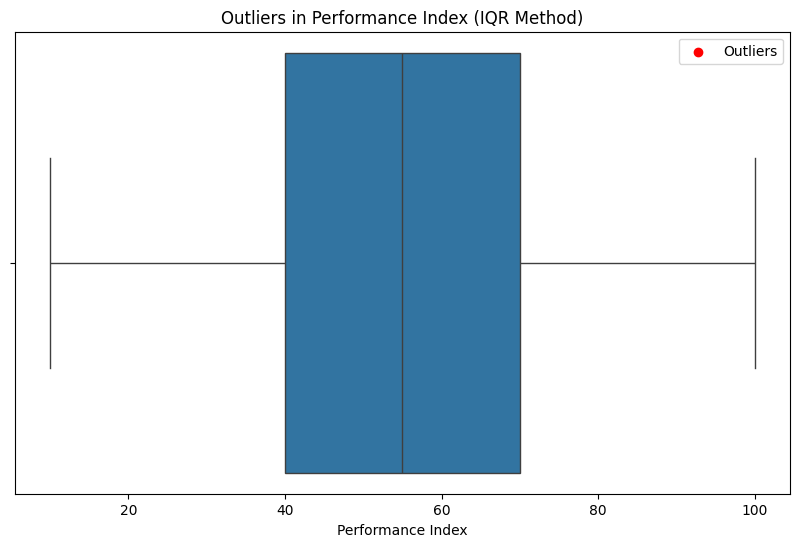

In [51]:
numerical_columns = df.select_dtypes(include=[np.number]).columns

def detect_outliers_iqr(df, column):

    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (df[column] < lower_bound) | (df[column] > upper_bound)

for column in numerical_columns:
    outliers = detect_outliers_iqr(df, column)
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[column])
    plt.scatter(df[column][outliers], [0] * sum(outliers), color="red", label="Outliers")
    plt.title(f"Outliers in {column} (IQR Method)")
    plt.xlabel(column)
    plt.legend()
    plt.show()

In [52]:
df_model = df.copy()

In [53]:
df_model['Extracurricular Activities'] = df_model['Extracurricular Activities'].map({'Yes': 1, 'No': 0})

df_model.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,1,9,1,91.0
1,4,82,0,4,2,65.0
2,8,51,1,7,2,45.0
3,5,52,1,5,2,36.0
4,7,75,0,8,5,66.0


In [54]:
numerical_columns = df.select_dtypes(include=['number']).columns

ranges = df[numerical_columns].agg(['min', 'max']).T
ranges['Range'] = ranges['max'] - ranges['min']
print(ranges)

                                   min    max  Range
Hours Studied                      1.0    9.0    8.0
Previous Scores                   40.0   99.0   59.0
Sleep Hours                        4.0    9.0    5.0
Sample Question Papers Practiced   0.0    9.0    9.0
Performance Index                 10.0  100.0   90.0


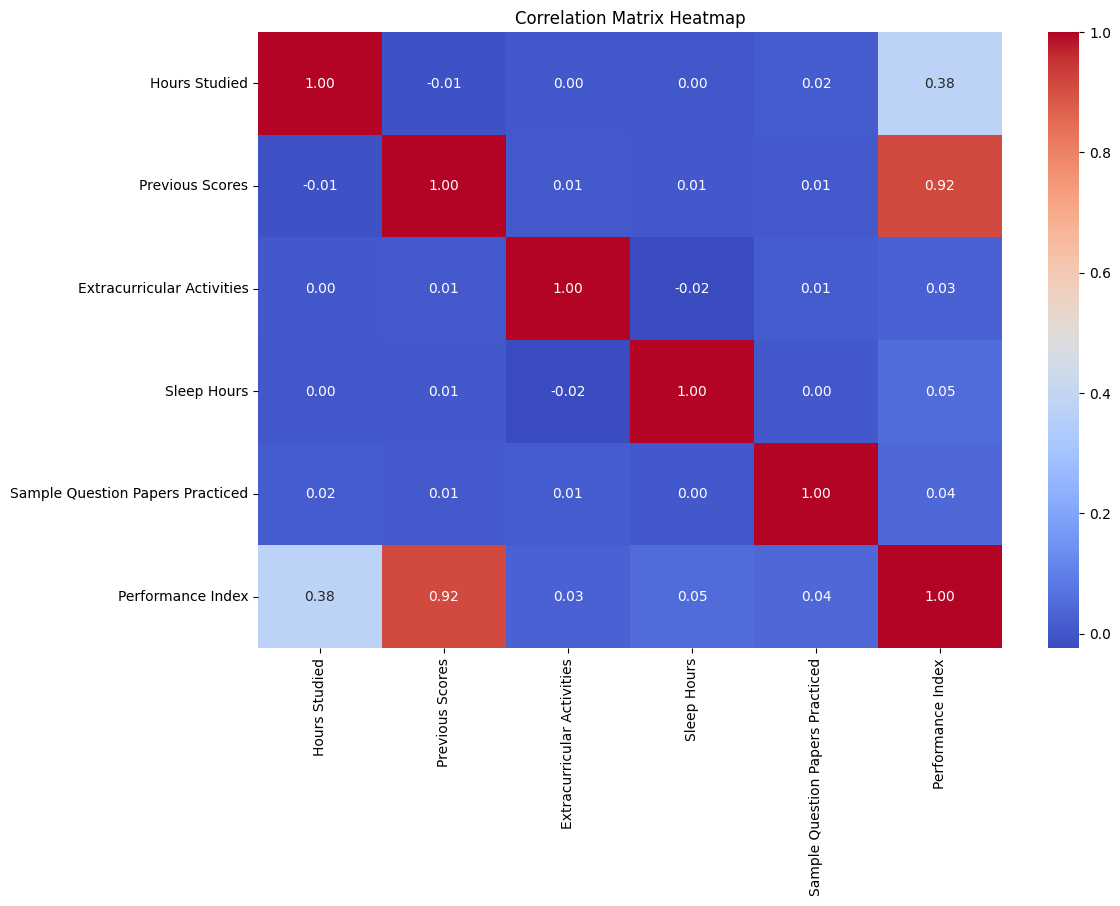

In [55]:
# Compute the correlation matrix for numerical columns
correlation_matrix = df_model.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix Heatmap")
plt.show()

### Calling Single Regression Functions

In [56]:
X = df_model[['Previous Scores']].values
Y= df_model[['Performance Index']].values

In [57]:
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)

In [58]:
model = SimpleLinearRegression()

# Fit the model
model.fit(X_scaled, Y_scaled)

In [59]:
# Predictions
y_pred_scaled = model.predict(X_scaled)

# Take a random sample (e.g., 20% of the data)
sample_fraction = 0.002  # Change this to the desired fraction
sample_size = int(len(X_scaled) * sample_fraction)

# Sample indices
random_indices = np.random.choice(len(X_scaled), size=sample_size, replace=False)

# Extract the sample for features and target
X_sample = X_scaled[random_indices]
Y_sample = Y_scaled[random_indices]

In [60]:
y_pred = scaler_Y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

In [61]:
# Add predictions to the DataFrame
df_model["Predicted Performance Index"] = y_pred

# Display the first few rows
df_model.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index,Predicted Performance Index
0,7,99,1,9,1,91.0,85.206907
1,4,82,0,4,2,65.0,67.958823
2,8,51,1,7,2,45.0,36.506436
3,5,52,1,5,2,36.0,37.521029
4,7,75,0,8,5,66.0,60.856671


In [62]:
# Retrieve coefficients
b0 = model.b0
b1 = model.b1

In [63]:
equation = f"y = {b0:.4f} + {b1:.4f} * x"

print(f"The best fit equation: {equation}")
print(f"Mean Squared Error: {model.MSE:.4f}")
print(f"Coefficient of determination (R²): {model.r_squared:.4f}")


The best fit equation: y = -0.0000 + 0.9151 * x
Mean Squared Error: 0.1626
Coefficient of determination (R²): 0.8375


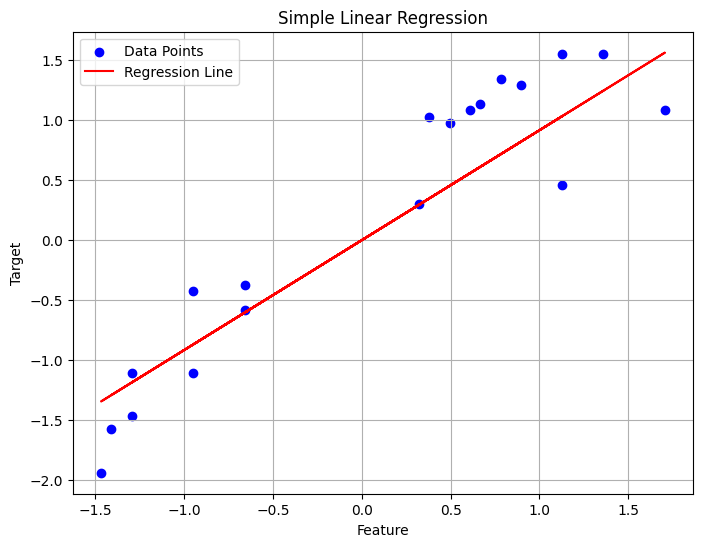

In [64]:
model.plot(X_sample, Y_sample)

In [65]:
model.anova_table()

,Source,Sum of Squares,Degrees of Freedom,Mean Square,F-Statistic
0,Regression,8268.363161,1,8268.363161,50863.230088
1,Error,1604.636839,9871,0.162561,
2,Total,9873.000000,9872,,


In [66]:
model.hypothesis_test()

 Hypothesis Testing Results 
Null Hypothesis (H₀):     β₁ = 0
Alternative Hypothesis:  β₁ ≠ 0
---------------------------------------------
F-statistic (F₀):        50863.2301
Critical value (F_c):    3.8424
---------------------------------------------
Conclusion: Reject H₀ — significant relationship exists.


In [67]:
B_0_est, B_1_est = model.interval_estimation()
print(f"95% CI for B_0: {B_0_est}")
print(f"95% CI for B_1: {B_1_est}")

95% CI for B_0: (np.float64(-0.007953981588944926), np.float64(0.007953981588944881))
95% CI for B_1: (np.float64(0.907181097613511), np.float64(0.9230890607914007))


### Calling Multiple Regression Functions

In [68]:
df_model_multi = df_model.copy()
df_model_multi.drop(columns=['Predicted Performance Index'], inplace=True)

In [69]:
X_multi = df_model_multi[['Previous Scores', 'Hours Studied']].values
Y_multi = df_model_multi[['Performance Index']].values

In [70]:
from sklearn.preprocessing import StandardScaler

scaler_X_multi = StandardScaler()
scaler_Y_multi = StandardScaler()

X_scaled_multi = scaler_X_multi.fit_transform(X_multi)
Y_scaled_multi = scaler_Y_multi.fit_transform(Y_multi)

In [71]:
model_multi = MultipleLinearRegression()

# Fit the model
model_multi.fit(X_scaled_multi, Y_scaled_multi)

In [72]:
# Predictions
y_pred_scaled_multi = model_multi.predict(X_scaled_multi)

# Take a random sample (e.g., 20% of the data)
sample_fraction = 0.002  # Change this to the desired fraction
sample_size = int(len(X_scaled_multi) * sample_fraction)

# Sample indices
random_indices = np.random.choice(len(X_scaled_multi), size=sample_size, replace=False)

# Extract the sample for features and target
X_sample_multi = X_scaled_multi[random_indices]
Y_sample_multi = Y_scaled_multi[random_indices]

In [73]:
y_pred_multi = scaler_Y_multi.inverse_transform(y_pred_scaled_multi.reshape(-1, 1)).flatten()

In [74]:
df_model_multi = df_model.copy()
df_model_multi["Predicted Performance Index"] = y_pred_multi

# Display the first few rows
df_model_multi.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index,Predicted Performance Index
0,7,99,1,9,1,91.0,91.079074
1,4,82,0,4,2,65.0,65.181227
2,8,51,1,7,2,45.0,45.017212
3,5,52,1,5,2,36.0,37.464096
4,7,75,0,8,5,66.0,66.619432


In [75]:
weights = model_multi.B
feature_count = len(weights) - 1

In [76]:
equation = f"y = {weights[0]} "
for i in range(1, feature_count + 1):
    equation += f"+ {weights[i]} * x{i} "
print(f"The best fit equation: {equation}")
print(f"Mean Squared Error: {model_multi.MSE}")
print(f'Coefficient of determination is: {model_multi.r_squared}')

The best fit equation: y = [-4.82144604e-18] + [0.91924682] * x1 + [0.38514574] * x2 
Mean Squared Error: 0.014211773328664303
Coefficient of determination is: 0.9857925450467014


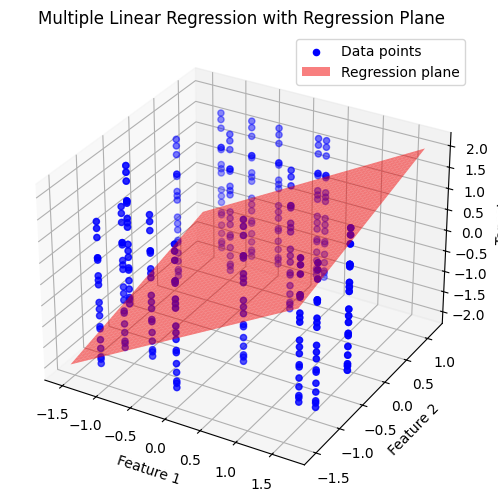

In [77]:
model_multi.plot(X_sample_multi, Y_sample_multi)

In [78]:
model_multi.anova_table()

,Source,Sum of Squares,Degrees of Freedom,Mean Square,F-Statistic
0,Regression,9732.729797,2,4866.364899,342417.852163
1,Error,140.270203,9870,0.014212,
2,Total,9873.000000,9872,,


In [79]:
model_multi.partial_f_test_all(X_scaled_multi, Y_scaled_multi, alpha=0.05)

Partial F-Test for Each Feature
Null Hypothesis H₀: β_i = 0  (feature j has no effect)
Alternative H₁:    β_i ≠ 0  (feature j contributes)
Significance level: α = 0.05
------------------------------------------------------------
Feature      F-stat  F-crit Conclusion
     B0 586969.6422  3.8424  Reject H₀
     B1 103038.9806  3.8424  Reject H₀


In [80]:
model_multi.hypothesis_test(alpha=0.05)

 Hypothesis Testing Results 
Null Hypothesis (H_0):    All coefficients except intercept are 0
Alternative Hypothesis (H_a): At least one coefficient ≠ 0
---------------------------------------------
F-statistic (F_0):        342417.8522
Critical value (F_c):     2.9966
---------------------------------------------
Since F_0 > F_c, we reject the null hypothesis.
Therefore, there's a relationship between the predictors and the target.


In [81]:
B_0_est, B_1_est, B_2_est = model_multi.interval_estimation(X_scaled_multi)
print(f"95% CI for B_0: {B_0_est}")
print(f"95% CI for B_1: {B_1_est}")
print(f"95% CI for B_2: {B_2_est}")


95% CI for B_0: (array([-0.0023518]), array([0.0023518]))
95% CI for B_1: (array([0.91689489]), array([0.92159876]))
95% CI for B_2: (array([0.3827938]), array([0.38749767]))


In [82]:
B_0_est, B_1_est, B_2_est = model_multi.interval_estimation(sigma=X.std(),X_scaled_multi=X_scaled_multi)
print(f"95% CI for B_0: {B_0_est}")
print(f"95% CI for B_1: {B_1_est}")
print(f"95% CI for B_2: {B_2_est}")

95% CI for B_0: (array([-0.3417353]), array([0.3417353]))
95% CI for B_1: (array([0.57749205]), array([1.2610016]))
95% CI for B_2: (array([0.04339096]), array([0.72690051]))
